<a href="https://colab.research.google.com/github/OJB-Quantum/Notebooks-for-Ideas/blob/main/Quantum%E2%80%91spin_evolution_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

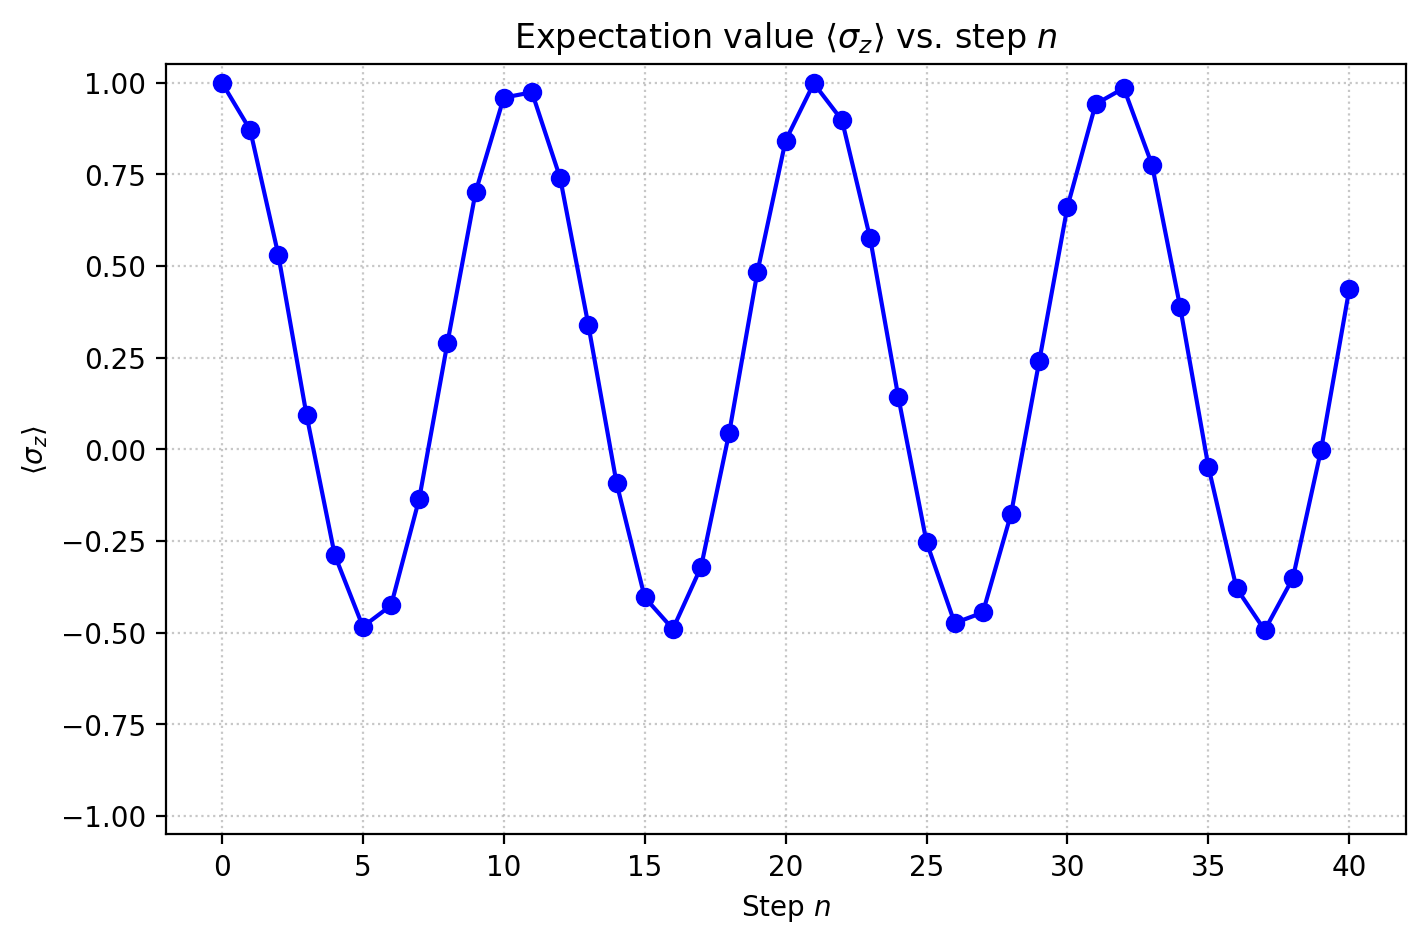

In [2]:
"""
Quantum‑spin evolution demo.

The script evaluates the recurrence
    ψℓ(t_{n+1}) = Q_A Q_V Q_m [S_z T_z(N*ℓ) S_z⁻¹]
                  [S_y T_y(N*ℓ) S_y⁻¹]
                  [S_x T_x(N*ℓ) S_x⁻¹] ψℓ(t_n)
for a two‑level (spin‑½) system and plots 〈σ_z〉(n).

The implementation uses NumPy + SciPy and follows PEP‑8 / PEP‑257.
"""

from __future__ import annotations

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm

plt.rcParams['figure.dpi'] = 200

# ----------------------------------------------------------------------
# 1.  Pauli matrices (used as generators of SU(2) rotations)
# ----------------------------------------------------------------------
SIGMA_X = np.array([[0.0, 1.0], [1.0, 0.0]], dtype=complex)
SIGMA_Y = np.array([[0.0, -1.0j], [1.0j, 0.0]], dtype=complex)
SIGMA_Z = np.array([[1.0, 0.0], [0.0, -1.0]], dtype=complex)

# ----------------------------------------------------------------------
# 2.  Helper functions
# ----------------------------------------------------------------------
def rotation_operator(pauli: np.ndarray, angle: float) -> np.ndarray:
    """
    Return the unitary rotation `exp(-i * angle/2 * pauli)`.

    Parameters
    ----------
    pauli : np.ndarray
        One of the Pauli matrices (σ_x, σ_y, σ_z).
    angle : float
        Rotation angle in radians.

    Returns
    -------
    np.ndarray
        2×2 unitary matrix.
    """
    return expm(-1j * angle / 2.0 * pauli)


def q_operator(hamiltonian: np.ndarray, dt: float) -> np.ndarray:
    """
    Return a short‑time propagator `exp(-i * H * dt)`.

    Parameters
    ----------
    hamiltonian : np.ndarray
        2×2 Hermitian matrix.
    dt : float
        Time step.

    Returns
    -------
    np.ndarray
        2×2 unitary matrix.
    """
    return expm(-1j * hamiltonian * dt)


def total_step_operator(dt: float, n_star: int, ell: int) -> np.ndarray:
    """
    Build the full evolution operator for a single step.

    The operator is the ordered product

        Q_A Q_V Q_m  (S_z T_z S_z⁻¹) (S_y T_y S_y⁻¹) (S_x T_x S_x⁻¹)

    where the three `Q`'s are simple Hamiltonian propagators and
    each `T` is a rotation around the corresponding axis.

    For the demo we choose
        H_A = 0.4 σ_x,   H_V = 0.3 σ_y,   H_m = 0.2 σ_z,
    and we set S_x = S_y = S_z = I (no basis change).

    Parameters
    ----------
    dt : float
        Time step Δt.
    n_star : int
        The integer `N*` that multiplies `ℓ` inside the `T`‑operators.
    ell : int
        The integer ℓ that appears in the formula.

    Returns
    -------
    np.ndarray
        2×2 unitary matrix that advances the state from `t_n` to `t_{n+1}`.
    """
    # ----- 3 simple propagators Q_A, Q_V, Q_m ---------------------------------
    h_a = 0.4 * SIGMA_X          # arbitrary choice
    h_v = 0.3 * SIGMA_Y
    h_m = 0.2 * SIGMA_Z

    q_a = q_operator(h_a, dt)
    q_v = q_operator(h_v, dt)
    q_m = q_operator(h_m, dt)

    # ----- Rotations T_x, T_y, T_z -------------------------------------------
    angle = n_star * ell * dt    # the argument of T_* in the paper
    t_x = rotation_operator(SIGMA_X, angle)
    t_y = rotation_operator(SIGMA_Y, angle)
    t_z = rotation_operator(SIGMA_Z, angle)

    # In this minimal example the similarity transforms are identities:
    s_x = np.eye(2, dtype=complex)
    s_y = np.eye(2, dtype=complex)
    s_z = np.eye(2, dtype=complex)

    # Assemble the full step operator (order matters!)
    step = (
        q_a @ q_v @ q_m @
        (s_z @ t_z @ np.linalg.inv(s_z)) @
        (s_y @ t_y @ np.linalg.inv(s_y)) @
        (s_x @ t_x @ np.linalg.inv(s_x))
    )
    return step


def evolve_state(
    psi0: np.ndarray,
    n_steps: int,
    dt: float,
    n_star: int,
    ell: int,
) -> tuple[np.ndarray, np.ndarray]:
    """
    Propagate the initial state `psi0` for `n_steps` time steps.

    Returns both the list of states and the list of 〈σ_z〉 expectation
    values (a scalar for every step).

    Parameters
    ----------
    psi0 : np.ndarray
        Normalised 2‑component column vector (shape (2, 1) or (2,)).
    n_steps : int
        Number of recurrence steps (i.e. the maximal `n`).
    dt : float
        Time step Δt.
    n_star : int
        The integer `N*` from the formula.
    ell : int
        The integer ℓ from the formula.

    Returns
    -------
    states : np.ndarray
        Array of shape (n_steps+1, 2) containing ψ(t₀), ψ(t₁), … ψ(t_n).
    sz_exp : np.ndarray
        Real array of length n_steps+1 with ⟨σ_z⟩ for each state.
    """
    # Ensure column‑vector shape (2,)
    psi = psi0.astype(complex).reshape(2)

    states = np.empty((n_steps + 1, 2), dtype=complex)
    sz_exp = np.empty(n_steps + 1, dtype=float)

    # Initial values
    states[0, :] = psi
    sz_exp[0] = np.real(np.vdot(psi, SIGMA_Z @ psi))

    # Recurrence
    step_op = total_step_operator(dt, n_star, ell)
    for k in range(1, n_steps + 1):
        psi = step_op @ psi
        # Renormalise to avoid numerical drift
        psi = psi / np.linalg.norm(psi)

        states[k, :] = psi
        sz_exp[k] = np.real(np.vdot(psi, SIGMA_Z @ psi))

    return states, sz_exp


def plot_expectation(n_array: np.ndarray, sz_exp: np.ndarray) -> None:
    """
    Plot ⟨σ_z⟩ as a function of the integer index `n`.

    Parameters
    ----------
    n_array : np.ndarray
        Array containing the integer steps (e.g. 0,1,2,…).
    sz_exp : np.ndarray
        Corresponding expectation values of σ_z.
    """
    plt.figure(figsize=(8, 5))
    plt.plot(n_array, sz_exp, marker="o", linestyle="-", color='blue')
    plt.title(r"Expectation value $\langle \sigma_z\rangle$ vs. step $n$")
    plt.xlabel("Step $n$")
    plt.ylabel(r"$\langle \sigma_z\rangle$")
    plt.grid(True, which="both", ls=":", alpha=0.7)
    plt.ylim(-1.05, 1.05)
    plt.show()


# ----------------------------------------------------------------------
# 3.  Main routine (executed when the notebook cell runs)
# ----------------------------------------------------------------------
# Time‑step and integer parameters
DELTA_T = 0.1          # Δt
N_STAR = 3            # N*
ELL = 1               # ℓ (choose 1 for simplicity)
N_MAX = 40            # largest n to display

# Normalised spin‑up state |↑⟩
psi_initial = np.array([1.0, 0.0], dtype=complex)

# Evolve
states, sz_expectation = evolve_state(
    psi0=psi_initial,
    n_steps=N_MAX,
    dt=DELTA_T,
    n_star=N_STAR,
    ell=ELL,
)

# Plot
plot_expectation(np.arange(N_MAX + 1), sz_expectation)
